We've previously talked about using [recurrent neural networks for generating text](http://andrew.gibiansky.com/blog/machine-learning/recurrent-neural-networks/), based on a similarly titled [paper](http://www.cs.utoronto.ca/~ilya/pubs/2011/LANG-RNN.pdf). Recently, recurrent neural networks have been [successfully applied](http://arxiv.org/pdf/1303.5778.pdf) to the difficult problem of speech recognition. In this post, we'll look at the architecture that Graves et. al. propose in that paper for their task.

# Neural Network Architecture

We will begin by discussing the architecture of the neural network used by Graves et. al. However, the architecture of the neural network is only the first of the major aspects of the paper; later, we discuss exactly *how* we use this architecture for speech recognition.

## Standard Recurrent Neural Networks

Recall that a *recurrent* neural network is one in which each layer represents another step in time (or another step in some sequence), and that each time step gets one input and predicts one output. However, the network is constrained to use the same "transition function" for each time step, thus learning to predict the output sequence from the input sequence for sequences of any length.

For a standard recurrent neural network, we iterate the following equations in order to do prediction:

$$\begin{aligned}
  h_i &= \sigma(W_{hh} h_{i-1} + W_{hx} x_i + b_h) \\
  \hat y_i &= W_{yh} h_i
\end{aligned}$$

The hidden layer at step $i$ is given by $h_i$; similarly, $x_i$ is the input layer at timestep $i$, $\hat y_i$ is output layer at timestep $i$, and the $W_*$ are the weight matrices (with biases $b_*$). 

Note that this formulation of recurrent networks (RNNs) is equivalent to having a one-hidden-layer feed-forward network at each timestep (with layers $x_i$, $h_i$, and $y_i$). One can also consider $h_{i-1}$ to be part of the input layer at each timestep.

## Long Short-Term Memory

Although standard RNNs are powerful in theory, they can be very difficult to train. Techniques such as Hessian-free optimization have been applied to them in order to improve training capacity. However, in addition to modifying the training algorithm, we can modify the network architecture to make it easier to train. 

One of the reasons training networks is difficult is that the errors computed in backpropoagation are multiplied by each other once per timestep. If the errors are small, the error quickly dies out, becoming very small; if the errors are large, they quickly become very large due to repeated multiplication. An alternative architecture built with *Long Short-Term Memory* (LSTM) cells attempts to negate this issue.

A single LSTM unit is shown below.

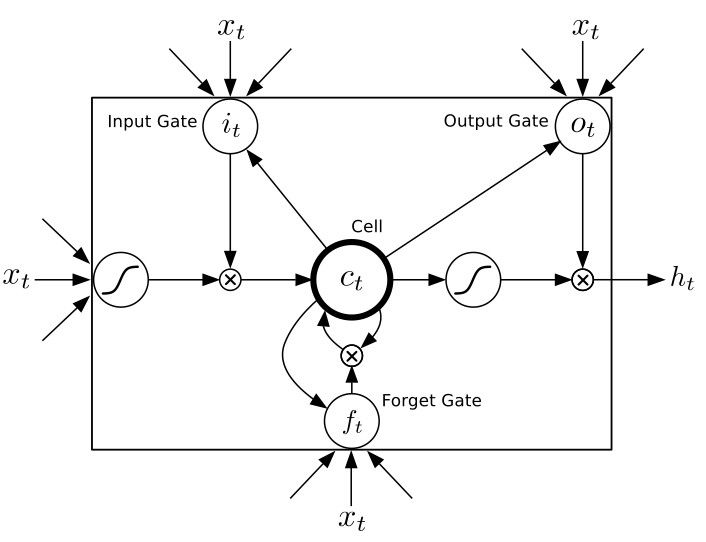

The inputs $x_t$ dictate the behaviour of our LSTM cell. Note that each of the cells (circles) shown above may actually be vectors, and can store a large set of values.

The intuition behind this memory unit is that the *cell* $c_t$ stores a value over time. It feeds itself and can either remember or forget its value, depending on the activation of the *forget gate* $f_t$. The cell can optionally output its value, depending on the activation of the *output gate* $o_t$. Finally, the cell acquires new values if the *input gate* $i_t$ allows it to. Note that in the diagram above, the $\otimes$ symbols indicate these complex activation functions that allow these behaviours.

Next, we present the equations that implement the LSTM unit. First of all, the cell $c_t$ must forget its value if the forget gate $f_t$ is low and acquire a new value if the input gate $i_t$ is high. The value it acquires is dictated by the previous hidden layer and the current input. Thus, $c_t$ is determined via the following equation:

$$
c_t = f_t c_{t-1} + i_t  \tanh(W_{hc} h_{t-1} + W_{xc} x_t + b_c)
$$

Note that when $f_t = 0$, the cell completely forgets its old value, and stores a new one. When $i_t = 1$, the new value is given by the inputs and the previous hidden layer; if the input gate is off, though, the cell is either unchanged (for $f_t = 1$) or simply set to zero (for $f_t = 0$). In this manner, the cell implements the main memory storage function of the unit.

In order to let $f_t$ and $i_t$ range from zero to one, we let their activation functions be the standard sigmoid, a differentiable approximation to the step function. Both of these are fairly standard, and depend on the input and previous values of the cell and hidden layers:

$$\begin{align*}
    f_t &= \sigma(W_{xf} x_t  + W_{hf} h_{t-1} + W_{cf} c_{t-1} + b_f) \\
    i_t &= \sigma(W_{xi} x_t  + W_{hi} h_{t-1} + W_{ci} c_{t-1} + b_i)
\end{align*}$$

The only caveat to these is that we enforce a constraint on the weight matrices from the cell to the gate. Recall that the gate is actually a vector of cells. We enforce the constraint that the $m$th gate element depends only on the $m$th cell element, so that each element of the LSTM unit acts independently. We encode this constraint by enforcing that $W_{c*}$ is a diagonal matrix.

In order to get the data *out* of the cell, we have a custom output gate. The output gate is computed just like the other two gates:

$$\begin{align*}
    o_t &= \sigma(W_{xo} x_t  + W_{ho} h_{t-1} + W_{co} c_{t-1} + b_o)
\end{align*}$$

The output gate controls whether the hidden state comes from the cell:

$$h_t = o_t \tanh c_t$$

When the output gate is high, the hidden state is set directly from the cell; when the output gate is low, the hidden state is effectively set to zero.

Note that in this diagram, $h$ is the entire hidden state. However, in a full RNN architecture we may want to mix LSTM units with standard RNN units, in which case $h$ may contain other things as well.

## Bidirectional RNNs

In a standard RNN, the output at a given time $t$ depends exclusively on the inputs $x_0$ through $x_t$ (via the hidden layers $h_0$ through $h_{t-1}$). However, while this makes sense in some contexts, many sequences have information relevant to output $y_t$ both before timestep $t$ and after timestep $t$. In speech recognition, specifically, the sound before and after a given point gives information about the sound at a particular point in the sequence. 

In order to utilize this information, we need a modified architecture. There are several approaches possible approaches:

- **Windowed Feed-Forward Network**: Instead of using an RNN, simply use a window around the output and use a standard feed forward network. This has a benefit of being easier to train; however, it limits applicability because we must have a window of *exactly* that size, and because we do not use information far away from the output (the size of the window is limiting).
- **RNN with delay**: Instead of predicting timestep $t$ after seeing inputs 0 through $t$, predict timestep $t$ after seeing inputs 0 through $t + d$, where $t$ is some fixed delay. This is fairly close to a standard RNN, but also lets you look a few steps in the future for contextual information.
- **Bidirectional RNN**: Add another set of hidden layers to your recurrent network going *backwards* in time. These two hidden layers are entirely separate and do not interact with each other, except for the fact that they are both used to compute the output. Given your weights, you need to run propagation forward in time (from time 0 to the end) to compute the forward hidden layers, and run it backward in time (from the end to time 0) to compute the backward hidden layers; finally, using the values at both of the hidden layers for a given timestep, compute the output at every timestep.

The [paper that introduced bidirectional RNNs](http://www.cin.ufpe.br/~fnj/RNA/BRNN.pdf) (by Schuster and Paliwal) has two graphics that are very helpful for understanding them and the differences from these other approaches. First of all, we can visualize what part of a sequence each type of network can utilize in order to predict a value at time $t_c$:

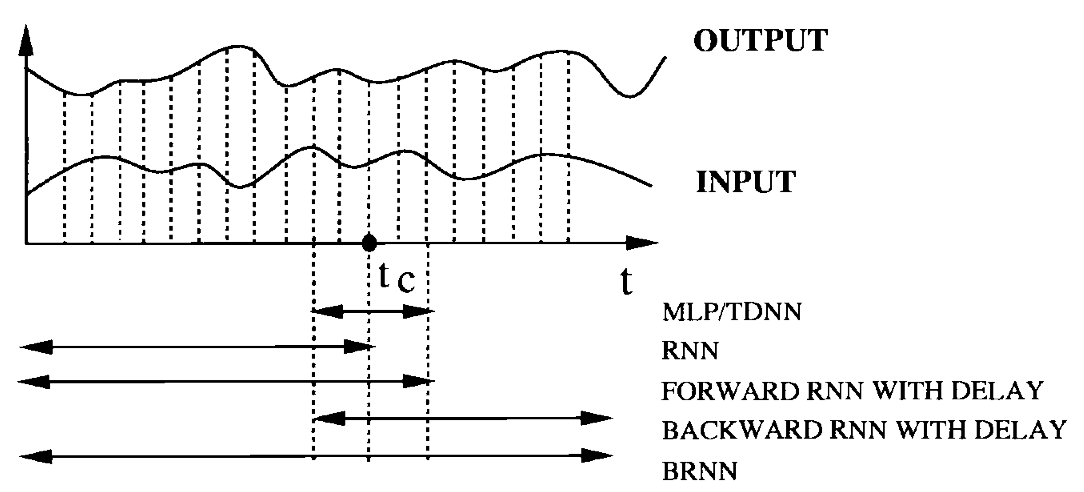

The windowed approach is labeled **MLP** (for multilayer perceptron). Standard RNNs are labeled **RNN**, and utilize information right up to $t_c$. Delayed RNNs (going forward and backward) can use all their history, with an extra window around $t_c$. Finally, bidirectional RNNs (**BRNN**s) can use the entire sequence for their prediction.

Graves et. al. propose using LSTM units in a bidirectional RNN for speech recognition, so we focus on that approach. It can be trained similar to a standard RNN; however, it looks slightly different when expanded in time (shown in the graphic below, also from Schuster and Paliwal).

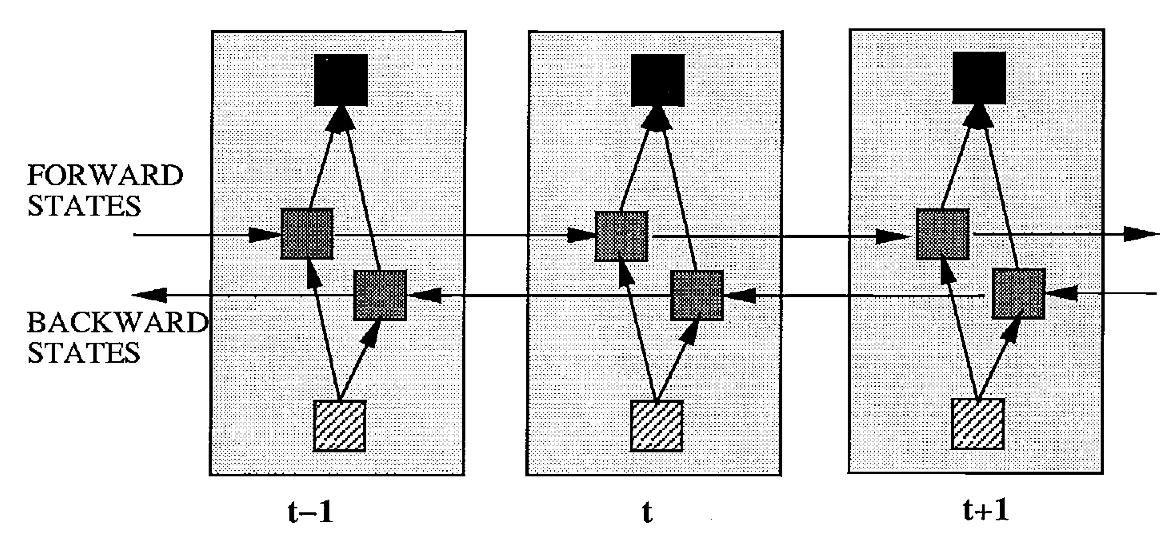

Here we see the BRNN expanded in time, showing only the timesteps around timestep $t$. We see that in the middle we have two hidden states (gray), one propagating forwards and one propagating backwards in time. The input (striped) feeds to both of these, and both of them feed to the output of the RNN (black).

## Final Architecture

The architecture ultimately proposed by Graves et. al. in their paper utilizes both BRNNs and LSTM units. However, in addition, they extend the architecture by adding more hidden layers at each timestep. Instead of only having one hidden layer between the input and the output, the BRNN has $N$ hidden layers. In a normal deep RNN, each hidden layer $h^n_t$ (at time $t$) receives input from the previous hidden layer $h^{n-1}_t$ as well as from the same hidden layer from the previous time step $h^n_{t-1}$. 

However, in a BRNN, each hidden layer has a direction associated with it; we can denote the two directions as $+$ and $-$, as in $h^{n,+}_t$ and $h^{n,-}_t$. Each hidden layer receives input not just from its previous timestep but also from the previous hidden layers *of both directions*. Thus, by utilizing a deep architecture, information from the end and beginning of a sequence can very effectively mix to form the prediction.

In addition, using LSTM units allows information to propagate for long distances both from the beginning and end of the sequence.

# Training an Acoustic Model

The first goal for speech recognition is to build a classifier which can convert from a sequence of sounds into a sequence of letters or phonemes. 

Suppose that we have an input sequence $x$ (sound data) and a desired output sequence $y$ (phonemes). However, even if our output sequence is short (say, two spoken words, maybe ten or twenty sounds), our input sequence will be much longer, as we will want to sample each sound many times to be able to distinguish them. Thus, $x$ and $y$ will be of different lengths, which poses a problem from our standard RNN architecture (in which we predict one output for one input).

We have several options for correcting this problem. The first option is to align the output sequence $y$ with the input sequence; each element $y_i$ of the output sequence is placed on some corresponding element $x_i$. Then, the network is trained to output $y_i$ at timestep $i$ (with input $x_i$) and output a "blank" element on timesteps for which there is no output. These sequences are said to be "aligned", since we've placed each output element $y_i$ in its proper temporal position.

Sadly, aligning the sequences is an onerous requirement. While unaligned data may be easy to come by (simply record sound and ask speakers to transcribe it), aligned data may be *much* harder to acquire; it may require careful aligning as well as understanding of the sounds being produced (and a sound understanding of phonology).

Instead of requiring aligned data, however, we can train our network directly on unaligned data. This requires some clever tricks, objective functions, and output decoding algorithms; collectively, this method is known as **Connectionist Temporal Classification**.

## Connectionist Temporal Classification

For the purposes of Connectionist Temporal Classification (CTC), consider the entire neural network to be simply a function that takes in some input sequence $x$ (of length $T$) and outputs some output sequence $y$ (also of length $T$). As long as we have an objective function on the output sequence $y$, we can train our network to produce the desired output.

Suppose that for each input sequence $x$ (sound data) we have a label $\ell$. The label is a sequence of letters from some alphabet $L$, which is potentially shorter than the input sequence $x$; let $U$ be the length of the label. They key idea behind CTC is that instead of somehow generating the label as output from the neural network, we instead generate a *probability distribution* at every timestep (from $t = 1$ to $t = T$). We can then decode this probability distribution into a maximum likelihood label. Finally, we train our network by creating an objective function that coerces the maximum likelihood decoding for a given sequence $x$ to correspond to our desired label $\ell$.

There are several moving parts here, and we will talk about them in order.

### Probability Distribution

Given an input sequence $x$ of length $T$, the network generates some output $y$ which parameterizes a probability distribution over the space of all possible labels. Let $L'$ be our alphabet $L$ with an extra symbol representing a "blank". The output layer of our network is required to be a softmax layer, which assigns a probability to each element of $L'$. Let $y_i(n)$ be the probability assigned by the network to seeing $n \in L'$ at time $t = i$.

The output generated by the network is known as a "path". The probability of a given path $\pi$ (given inputs $x$) can then be written as the product of all its constituent elements:

$$P(\pi | x) = \prod_{t=1}^T y_t(\pi_t), \text{ where $\pi_t$ is the $t^\text{th}$ element of the path $\pi$}$$

Note that this assumes that the outputs are all conditionally independent (given the internal state of the network); we ensure this by forbidding connections from the output layer to other output layers or to other hidden layers.

If we traverse the path by removing all blanks and duplicate letters, we get some label. Note that we remove duplicate letters in addition to blanks; effectively, this means we really care about *transitions* from blanks to letters or from a letter to another letter. Let label($\pi$) be the label corresponding to a path $\pi$. Thus, the probability of seeing a particular label $\ell$ given the input sequence $x$ can be written as the sum of all the path probabilities over the paths that get us that label:

$$P(\ell | x) = \sum_{\text{label}(\pi) = \ell} P(\pi | x) = \sum_{\text{label}(\pi) = \ell} \prod_{t=1}^T y_t(\pi_t)$$

### Output Decoding

Given the probability distribution $P(\ell | x)$, we can compute a label $\ell$ for an input sequence $x$ by taking the most likely label. Thus, given that $L^{\le T}$ is the set of sequences of length less than or equal to $T$ with letters drawn from the alphabet $L$, we can express our desired classifier $h(x)$ as follows:

$$h(x) = \arg \max_{\ell \in L^{\le T}} P(\ell | x)$$

Computing the most likely $\ell$ from the probability distribution $P(\ell | x)$ is known as *decoding*. However, given that the alphabet $L$ and the maximum sequence length $T$ may be quite large, it is computationally intractable to examing every possible $\ell \in L^{\le T}$. There is no known algorithm to efficiently compute this $h(x)$ precisely; however, there are several ways to approximate decoding which work well enough in practice.

Traditionally, decoding is done in one of two ways, which we discuss now. However, note that Graves et. al. do not end up using either of these ways, as they augment the CTC-style network in several ways, and find that a different decoding strategy works better in that context.

#### Best Path Decoding

The first traditional decoding strategy is *best path decoding*, which assumes that the most likely path corresponds to the most likely label. This is not necessarily true: suppose we have one path with probability 0.1 corresponding to label $A$, and ten paths with probability 0.05 each corresponding to label $B$. Clearly, label $B$ is preferable overall, since it has an overall probability of 0.5; however, best path decoding would select label $A$, which has a higher probability than any path for label $B$.

Best path decoding is fairly simple to compute; simply look at the most active output at every timestep, concatenate them, and convert them to a label (via removing blanks and duplicates). Since at each step we choose the most active output, the resulting path is the most likely one.

#### Prefix Search Decoding

As an alternative to the naive best path decoding method, we can perform a search in the label space using heuristics to guide our search and decide when to stop. One particular set of heuristics yields an algorithm called *prefix search decoding*, which is somewhat inspired by the [forward-backward algorithm](http://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm) for hidden Markov models. 

The intuition behind prefix search decoding is that instead of searching among all labels, we can look at prefixes of strings. We continue growing the prefixes by appending the most probable element until it is more probable that the prefix ends (the string consists only of that prefix), at which point we stop.

The search proceeds as follows:

1. At each step, we maintain a list of growing prefixes. Initialise this list with a single element consisting of the empty prefix. Along with each prefix store its probability; we know that the empty prefix has probability one.

2. Find the most likely prefix. Consider each possible extension of the prefix, or consider terminating the prefix and ending the string.

3. Compute the probability of each of these options.

4. If terminating the prefix has a higher probability than extending this or any other prefix, terminate the prefix; we have found our decoding.

5. If extending the prefix has a higher probability than terminating it, extend the prefix and store it with the new probability (instead of the old, shorter prefix).

6. Iterate these steps until you have found your decoding.

Note that if given enough time, prefix search will find the true best decoding, and may thus require exponentially many prefixes. However, if the output distribution is concentrated around the best decoding, the search will finish significantly faster; also, heuristics may be used to speed it up. (For instance, [Graves et. al.](ftp://ftp.idsia.ch/pub/juergen/icml2006.pdf) cut the sequence into chunks which are likely to start and end with a blank by segmenting based on the probability of a blank, and then run prefix search on the small chunks.)

Graves et. al. provide the following diagram to help understand this process in [their paper describing CTC networks](ftp://ftp.idsia.ch/pub/juergen/icml2006.pdf):

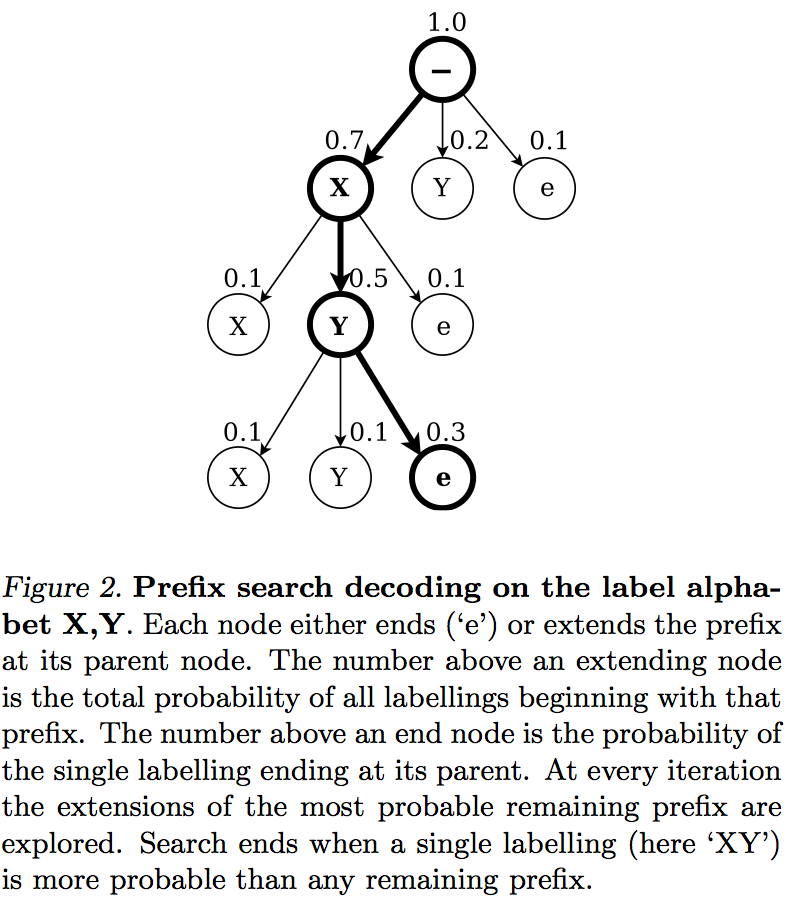



Note that at this point we have said nothing about *how* we can compute the probability of a prefix once we extend it, which is what we address next.

To efficiently compute the probability of a prefix, we define some extra values which we will compute incrementally in a dynamic programming algorithm. Let $\gamma_t(p_n)$ be the probability that the prefix $p$ is seen at time $t$ and that the last seen output is a non-blank ($n$ stands for non-blank). Similarly, let $\gamma_t(p_b)$ be the probability that the prefix $p$ is seen at time $t$ and the last seen output is a blank ($b$ stands for blank). Note that these are probabilities that the prefix *and nothing else* have been seen at time $t$. Then, the probability that a given prefix $p$ is the entire labeling is given by

$$P(p|x) = \gamma_T(p_n) + \gamma_T(p_b),$$

where $T$ is the length of our sequence. Also, let us define the harder-to-compute probability of seeing a prefix $p$ that has a non-empty string following it as

$$P(p\ldots|x) = \sum_{\ell \ne \varnothing} P(p + \ell | x)$$

With these in mind, we can proceed to implement the search algorithm described earlier. First, we must initialize all our values. We know that for any $t$, we can compute the probability of seeing nothing by that $t$:

$$\begin{align*}
\gamma_t(\varnothing_n) &= 0 \\
\gamma_t(\varnothing_b) &= \prod_{i=1}^t y_i(b)
\end{align*}$$

To understand the first of these, note that it's impossible that we see nothing when the path doesn't end in a blank (since then we'd have seen that non-blank). For the second, note that in order to see nothing and have it end in a blank, we simply multiply the probabilities of seeing blanks at every timestep up to $t$.

Next, initialize our set of prefixes to $P = \{\varnothing\}$, the set containing only the empty prefix. Let $\ell^*$ be the growing output labeling, and let $p^*$ be the current prefix we're looking at. Initialize both of these to the empty string as well.

We now begin iteratively growing our prefixes, extending them by one character at a time. If $p^*$ is the current best prefix, all the prefixes we wish to consider next are of the form $p' = p^* + k$, where $k$ is a character in our alphabet. For each, we wish to compute the probability that this prefix is the entire labeling, $P(p'|x) = P(p^*+k|x)$, as well as the probability that the best labeling starts with this prefix, $P(p'\ldots|x)$. We can compute these using a dynamic programming algorithm with $\gamma_t(x)$, by starting with initial values at $\gamma_1(x)$ and building up through time.

Thus, initialize $\gamma_1(p'_n)$ and $\gamma_1(p'_b)$. Intuitively, $\gamma_1(p'_b)$ must be zero, because $p'$ does not end in a blank (it ends in $k$) and at time zero if we output a blank we clearly could not have seen $p'$. On the other hand, $\gamma_1(p'_n)$ can be non-zero if $p'$ consists *only* of $k$, in which case $\gamma_1(p'_n) = y_1(k)$.

We now have values of $\gamma$ at $t = 1$. In addition, let us define the probability that we the last character in $p'$ appear at time $t$. Since the last character is $k$, this probability is the probability that seeing a $k$ at time $t$ would indeed be a new character:

$$\text{new}(t) = \gamma_{t-1}(p^*_b) + \begin{cases}0 & \text{if $p^*$ ends in $k$}\\ \gamma_{t-1}(p^*_n) & \text{otherwise}\end{cases}$$

This equation says that we have two ways in which seeing a $k$ can yield a new character: either the previous timestep we had a sequence which ended in a blank, or we had a sequence which ended in a non-$k$ character.

With this value, we can compute $\gamma$ for time $t$ if we have computed it for times less than $t$:

$$\begin{align*}
\gamma_t(p'_n) &= y_t(k) \big(\text{new}(t)  + \gamma_{t-1}(p'_n)\big) \\
\gamma_t(p'_b) &= y_t(b) \big(\gamma_{t-1}(p'_b)  + \gamma_{t-1}(p'_n)\big)
\end{align*}$$

These equations are fairly intuitive. For the first one, to end in a non-blank and generate $p'$, we must end with $k$ (thus the $y_t(k)$); in order to have generated $p'$, $k$ must either be a new label or we must have already generated all of $p'$ (with $k$ included) at the previous timestep (thus the $\gamma_{t-1}(p'_n)$). For the second equation, to generate $p'$ and end in a blank, we must clearly have a blank as the last character, and at the previous timestep we must have generated all of $p'$ (and ended with blank or non-blank).

With $\gamma$ fully computed up through the sequence length $T$, we can now compute the quantities we are interested in, namely $P(p'\ldots|x)$ and $P(p'|x)$. As we said before,

$$P(p'|x) = \gamma_T(p'_n) + \gamma_T(p'_b)$$

We now have values for $\gamma$, so we can compute this numerically. 

In order to compute $P(p'\ldots|x)$, we simply compute the probability of seeing $p'$ as a prefix and subtract the probability of seeing it as the entire label. The probability of seeing it as the entire label is the value we just computed, $P(p'|x)$. The probability of seeing $p'$ as a prefix can be written as

$$P(p' \text{ is a prefix }|x) = \gamma_1(p'_n) + \sum_{t=2}^T y_t(k) \cdot \text{new}(t),$$

because we simply consider separately the possibilities that we see $p'$ as a prefix *for the first time* at every time $t$. (For $t=1$, that's just $\gamma_1(p'_n)$, since there's no way to have seen $p'$ as a prefix before; for other $t$, it's exactly the probability of seeing $k$ times the probability new$(t)$ that we're seeing a new character being generated, which we computed before.) Thus, we can write $P(p'\ldots|x)$ as

$$P(p'\ldots|x) = \gamma_1(p'_n) + \sum_{t=2}^T y_t(k) \cdot \text{new}(t) - P(p'|x).$$

Now we have the probability of each extended prefix and the probability of ending with each one. When you compute these for a prefix, do the following:

1. If our prefix is a better labeling than $\ell^*$ ($P(p'|x) > P(\ell^*|x)$), update our best labeling $\ell^*$.
2. If the probability of starting with $p'$ is higher than our labeling ($P(p'\ldots|x) > P(\ell^*|x)$, add it to the list of prefixes we're considering $P$.

After looking at each of the extensions of $p^*$:

- Get rid of $p^*$ from the list of prefixes we're considering.
- Update $p^*$ by choosing it to be the prefix that maximizes $P(p^*\ldots|x)$ (the prefix that the labeling is most likely to start with).

We wish to continue growing our prefix until the current estimate of the best labeling has higher probability than any of our other options from the best prefix. The probability of extending the best prefix is just $P(p^*\ldots|x)$, and the best labeling has probability $P(\ell^*|x)$, so we iterate until $P(p^*\ldots|x) < P(\ell^*|x)$. After each step, we have these values, so we can easily test for termination. Once we're done, $\ell^*$ will contain our best labeling, and decoding will be complete.

This entire algorithm is summarized in the following graphic, taken from [Alex Graves' dissertation](http://deeplearning.cs.cmu.edu/pdfs/1104/Supervised_Sequence_Labeling.pdf):

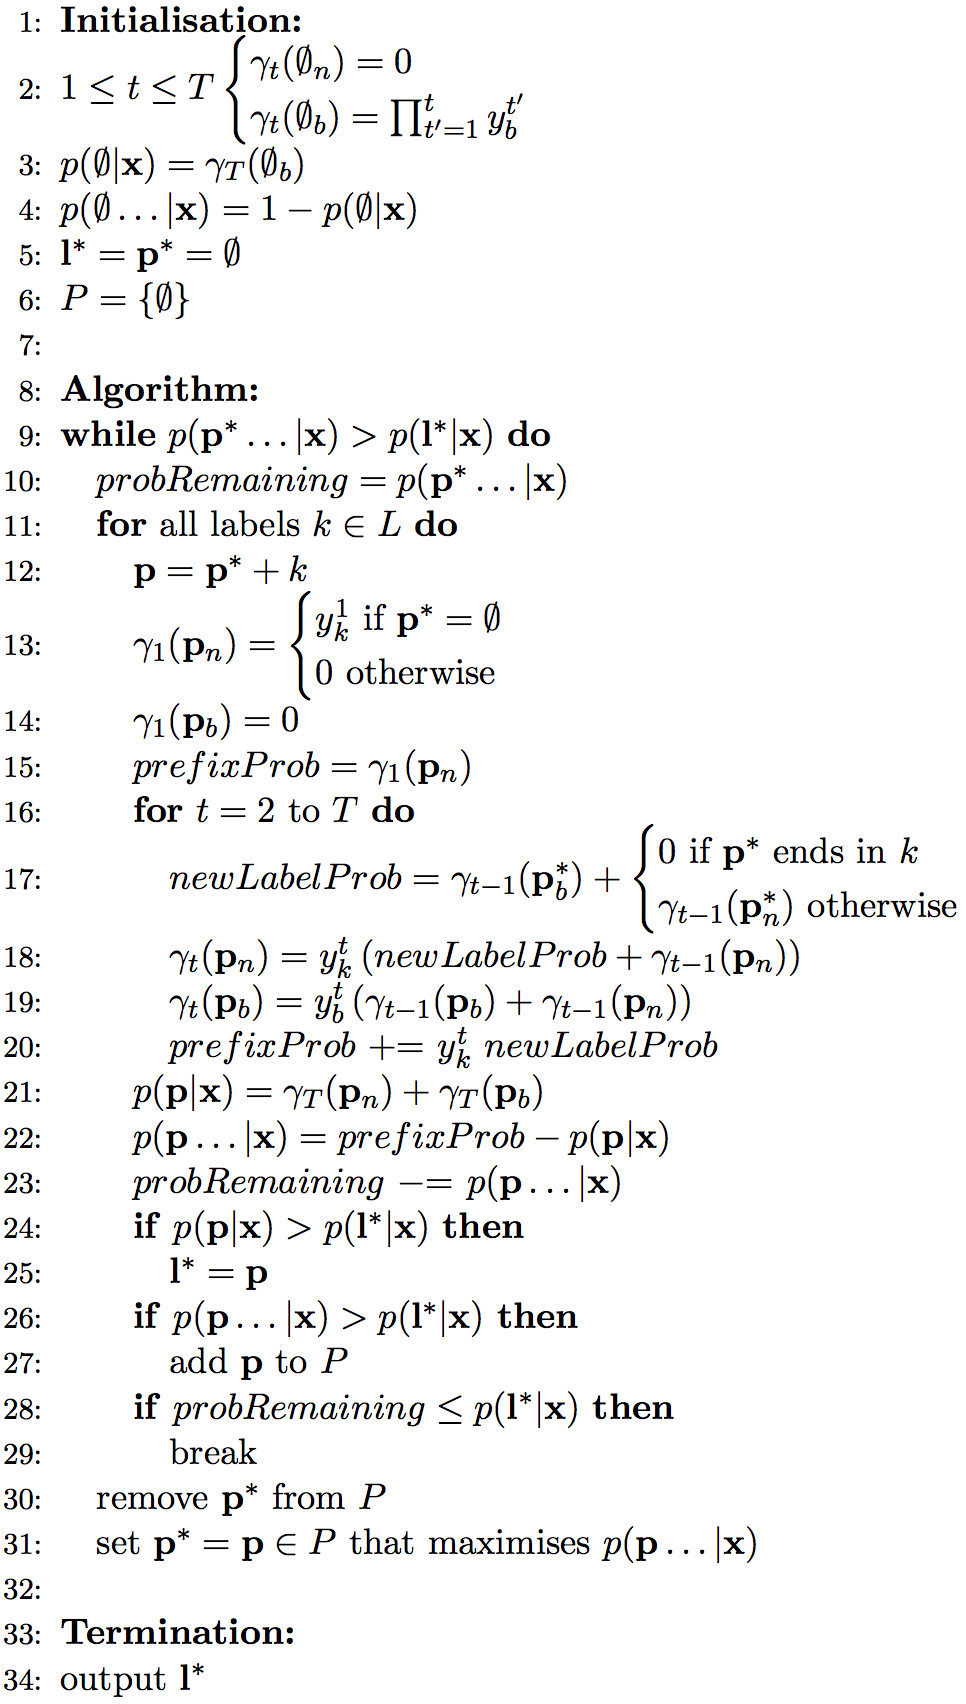

#### Formulating an Objective

Now that we have defined the probability distribution used in CTC networks as well as figured out how to decode the CTC network output, we are left with the question of how we can train our CTC networks. In order to train our network, we need an objective function, which we can then minimize via some standard minimization algorithm (such as gradient descent or hessian free optimization). In this section, we derive this objective function.

The objective function is based off maximum likelihood; minimizing the objective function *maximizes* the (log) likelihood of observing our desired label. We begin by deriving this likelihood function; namely, we wish to compute $P(\ell|x)$ where $\ell$ is the label and $x$ is the input sequence.

Naively computing this is computationally intractable, as demonstrated via the following equation (which we came up with above):

$$P(\ell | x) = \sum_{\large\text{label}(\pi) = \ell} P(\pi | x) = \sum_{\text{label}(\pi) = \ell} \prod_{t=1}^T y_t(\pi_t)$$

However, we can compute this efficiently via a dynamic programming algorithm similar to the one we used to do decoding. This algorithm, however, has a forward and backward pass. The forward pass computes probabilities of prefixes, and the backward pass computes probabilities of suffixes.

The maximum likelihood function works by probabilistically matching elements of the label sequence with elements of the output sequence. We know that the output sequence will have many blanks; in particular, we expect that there will very often be a blank between successive letters. To simplify our matching, we can account for this by adjusting our mental model of the label we're matching. Thus, instead of considering a label $\ell$, we consider a modified label $\ell'$, which is just $\ell$ with blanks inserted between all letters, as well as at the beginning and end. This way, if the network outputs blanks between its letters, they will correspond to existing blanks between the letters in the label. Since we have a blank between each pair of letters and at the beginning and end, the lengths of the new sequence is $|\ell'| = 2|\ell| + 1$ (if $|\ell|$ is the length of the original sequence).

Let $\ell'_{1:q}$ be the substring of $\ell'$ that starts at element 1 and ends at element $q$ (such that $\ell'_{1:0}$ is the empty string). Then, let $\alpha_t(s)$ be the probability that the prefix $\ell'_{1:s}$ is observed by time $t$. We can write this probability by summing over all paths $\pi$ that contain $\ell'_{1:s}$ in their first $t$ elements (label$(\pi_{1:t}) = \ell'_{1:s}$):

$$\alpha_t(s) = \sum_{\large\text{label}(\pi_{1:t}) = \ell'_{1:s}} p(\pi | x)= \sum_{\large\text{label}(\pi_{1:t}) = \ell'_{1:s}} 
\prod_{j=1}^t y_j(\pi_j)$$

Note that the probability of $\ell$ is the combined probability of $\ell'$ with and without the last blank:

$$P(\ell|x) = \alpha_T(|\ell'|) + \alpha_T(|\ell'|-1).$$

We compute $\alpha$ via the following dynamic programming algorithm. We start by initializing $\alpha$ for time $t = 0$:
$$\begin{align*}
\alpha_0(0) &= 1 \\
\alpha_0(i) &= 0 \text{ (for $i > 0$)}
\end{align*}$$
Before any data is presented we cannot predict any elements of the label (and thus the probability of the empty string must be one, and the probability of a non-empty string is zero.)

This forms a base case. Next, we can compute any other $\alpha_t(s)$ via the following recursive relations (where $b$ is a blank):

$$\alpha_t(s) = \begin{cases}
y_t(\ell'(s)) \cdot (\alpha_{t-1}(s) + \alpha_{t-1}(s-1)) & \text{if } \ell'(s) = b \text{ or } \ell'(s - 2) = \ell'(s)\\
y_t(\ell'(s)) \cdot (\alpha_{t-1}(s) + \alpha_{t-1}(s-1) +  + \alpha_{t-1}(s-2)) & \text{otherwise}
\end{cases}$$

These relations may initially seem fairly cryptic, so let us look at each one in turn.

- Suppose $\ell'(s) = b$: the last letter in our prefix is a blank. In this case, we have two ways in which we will have seen this prefix by time $t$. First, we could have seen the entire prefix by time $t-1$, followed by seeing a blank (which does nothing). This probability is just $y_t(\ell'(s)) \cdot \alpha_{t-1}(s)$, where $y_t(\ell'(s))$ corresponds to seeing the blank and $\alpha_{t-1}(s)$ corresponds to seeing the entire prefix by time $t-1$. The other way in which we can see this prefix by time $t$ is if we see everything but the last blank by time $t-1$ and we see a blank at time $t$; for this, the probability is $y_t(\ell'(s)) \alpha_{t-1}(s-1)$.

- Suppose $\ell'(s) = \ell'(s-2)$: our original sequence $\ell$ has two repeated letters, and we stuck a blank in between them. Once more, we have two ways in which we can get our full prefix $\ell'_{1:s}$ by time $t$. First, if we have already seen the prefix by time $t-1$, we can just see another $\ell'(s)$ and the repeated $\ell'(s)$ will just be removed; the probability of seeing that repeated $\ell'(s)$ is $y_t(\ell'(s)) \alpha_{t-1}(s)$. Second, if we have seen everything but the last letter, then we must see the last letter at time $t$; this probability is $y_t(\ell'(s)) \alpha_{t-1}(s-1)$. Note that the sum of this case is identical to that of the previous case.
- Finally, suppose we have non-blank $\ell'(s)$ which is distinct from the previous non-blank, $\ell'(s-2)$. In that case, we have the same options as before, except we have a third which corresponds to outputting $\ell'(s)$ immediately after $\ell'(s-2)$ (with no intervening blank). That will happen if we have seen $\ell'(s-2)$ by time $t-1$ and immediately see $\ell'(s)$ afterwards; this probability is $y_t(\ell'(s))\alpha_{t-1}(s-2)$, and forms the last term in the second case.

Note also that for any for any $s$ that is smaller than $|\ell'| - 2(T-t)-1$, we do not have enough time steps to complete the rest of the sequence, so $\alpha_t(s) = 0$. Thus, we can compute $\alpha_t(s)$ for any $t$, $s$, and $\ell'$; we can also thus compute $P(\ell|x)$ for any $\ell$ and $x$.

We can now formulate our objective function. Given the dataset $S = \{(x, \ell)\}$ of training samples where $x$ is the input and $\ell$ is the desired output, we wish to maximize the likelihood (log probability) of each training sample, which corresponds to minimizing the following objective function:

$$\mathcal{O}(S) = -\sum_{(x, \ell) \in S} \ln P(\ell|x).$$

#### Training the Network

Now that we have an objective function, can devise a training algorithm to minimize it. As we'll see, this is where the *backwards* pass of our forward-backward algorithm comes into play. We minimize it by taking the gradient with respect to the weights, at which point we can use gradient descent.

The difficulty in this minimization comes from the fact that we need to compute the derivative with respect to the neural network outputs $y_t$, since our objective is a fairly complicated function of these outputs. Once we have the derivatives with respect to the neural network outputs $y_t$, we can use standard neural network backpropagation to compute the derivatives with respect to the weights. Note also that since all training samples are independent, we will just compute our derivatives for a single training sample; simply sum over all training samples to deal with the entire dataset.

In order to compute our gradients, we are going to need our set of backwards variables. Thus, let $\beta_t(s)$ be the probability that $\ell'_{s:|\ell'|}$ is observed after time $t$; that is, the probability that the $|\ell'|-s$-length suffix of $t$ is seen starting at time $t$. If $\pi$ are paths, we define these variables as the sum of the path probabilities over all paths with the desired suffix:

$$\beta_t(s) = \sum_{\large\text{label}(\pi_{t:T}) = \ell'_{s:|\ell'|}} \prod_{i=t}^T y_i(\pi(i))$$

As before, we have some fairly convenient initializations, this time at time $t = T$:

$$\begin{align*}
\beta_T(|\ell'|)  &= y_T(b) \\
\beta_T(|\ell'| - 1)  &= y_T(\ell_{|\ell|}) \\
\end{align*}$$

The above equations simply state that the probability of seeing the last character as a suffix at time $t$ is the probability of seeing the network output that character at time $t$ (with or without the blank trailing $\ell'$). We also know that it's impossible to see a two or more character suffix if we're only looking at the last time output:

$$\beta_T(s) = 0 \text{ for all } s < |\ell'| - 1.$$

Next, we define the recursive relations that allow us to compute $\beta_t(s)$ for any other $s$ and $t$. Unsurprisingly, they look like backwards versions of the $\alpha_t(s)$ relations:

$$\beta_t(s) = \begin{cases}
y_t(\ell'(s))\cdot (\beta_{t+1}(s) + \beta_{t+1}(s+1)) & \text{ if $\ell'(s) = b$ or $\ell'(s) = \ell'(s+2)$} \\
y_t(\ell'(s))\cdot (\beta_{t+1}(s) + \beta_{t+1}(s+1) + \beta_{t+1}(s+2)) & \text{ otherwise} \\
\end{cases}$$
The reasoning from before carries over as well, as long as you keep in mind that $\beta_t(s)$ is the probability of seeing the $|\ell'|-s$ length suffix of $\ell'$ starting at time $t$.

Now, we have $\alpha_t(s)$, the probability of $s$-length prefix being seen at time $t$, as well as $\beta_t(s)$, the probability of the $|\ell'|-s$ length suffix being seen at time $t$. The next key insight is that if we have both $\beta_t(s)$ and $\alpha_t(s)$, we are observing symbol $s$ at time $t$, because if we were observing *anything* else, either the suffix or the prefix would not be observed exactly at time $t$. Thus, $\alpha_t(s)\beta_t(s)$ is the probability of all paths corresponding to $\ell$ that go through symbol $s$ at time $t$. Specifically, recall the definitions of $\alpha$ and $\beta$:

$$\begin{align*}
\alpha_t(s) &= \sum_{\large\text{label}(\pi_{1:t}) = \ell'_{1:s}} \prod_{j=1}^t y_j(\pi_j)\\
\beta_t(s) &= \sum_{\large\text{label}(\pi_{t:T}) = \ell'_{s:|\ell'|}} \prod_{i=t}^T y_i(\pi(i))
\end{align*}$$

Now, consider the terms of the product $\alpha_t(s)\beta_t(s)$. Each of these is a term from the $\alpha_t(s)$ times a term from the $\beta_t(s)$ sum. Since each term is for a distinct prefix or suffix, the cross product of these two sets yields all possible prefixes and suffixes. The only constraint is that the prefixes and suffixes end and start with symbol $s$ at time $t$; that is, that the paths have $s$ emitted at time $t$. When we multiply two terms (both of which are products over the path) from the two sums, the resulting term is also just a product over the path. Since $\alpha_t(s)$ contributes a product over the prefix and $\beta_t(s)$ contributes a product over the suffix, the result is a product over the entire path. Note, however, that since both the suffix and prefix include $s$, we have to avoid double counting it, so we divide by $y_t(\ell'(s))$. This yields the equation

$$\frac{\alpha_t(s)\beta_t(s)}{y_t(\ell'(s))} = \sum_{\substack{\large\text{label}(\pi) = \ell\\\large\pi(t) = \ell'(s)}} \prod_{t=1}^T y_t(\pi(t))= \sum_{\substack{\large\text{label}(\pi) = \ell\\\large\pi(t) = \ell'(s)}} P(\pi|x)$$

In the equation above, we are summing over all paths that have symbol $s$ at time $t$. We know that *some* symbol from the path must exist at time $t$, though. Thus, the *total* probability of $\ell$ is the sum of the probabilities that any *s* appears at time $t$. Thus, we can write that

$$P(\ell|x) = \sum_{s=1}^{|\ell'|} \frac{\alpha_t(s)\beta_t(s)}{y_t(\ell'(s))}.$$

Note that this is valid *for any* $t$ from 1 to $T$. Thus, we can differentiate this probability with respect to $y_t(k)$ for any character $k$ in the alphabet (or blank) and time $t$. Note though that a sequence $\ell'$ may have many instances of $k$, so let $\text{loc}(\ell', k)$ be the set of locations $s$ such that $\ell'(s) = k$. Then, we can write the derivative as

$$\frac{\partial}{\partial y_t(k)} P(\ell|x) = \frac{1}{y_t(k)^2} \sum_{\large s \in \text{loc}(\ell', k)} \alpha_t(s)\beta_t(s)$$

Recall that the final objective function is actually the natural log of the probability. However, we know that

$$\frac{\partial}{\partial y_t(k)} \ln P(\ell|x) = \frac{1}{P(\ell|x)}\frac{\partial}{\partial y_t(k)} P(\ell|x)$$

and that the probability itself may be written as

$$P(\ell|x) = \alpha_T(|\ell'|)+\alpha_T(|\ell'|-1),$$

which leads us to our final objective function for the CTC network:

$$\frac{\partial}{\partial y_t(k)} \ln P(\ell|x) = \frac{1}{y_t(k)^2\cdot(\alpha_T(|\ell'|)+\alpha_T(|\ell'|-1))} \sum_{\large s \in \text{loc}(\ell', k)} \alpha_t(s)\beta_t(s)$$

This concludes our analysis of connectionist temporal classification (CTC) networks; the details may be accessed in [this paper](ftp://ftp.idsia.ch/pub/juergen/icml2006.pdf) and [Alex Graves' dissertation](http://deeplearning.cs.cmu.edu/pdfs/1104/Supervised_Sequence_Labeling.pdf), both of which address several other issues which arise in practice with CTC networks, and include experimental findings related to their use.

# Training a Linguistic Model

The connectionist temporal classification model we described above does a good job as an acoustic model; that is, it can be trained to predict the output phonemes based on the input sound data. However, it does not account for the fact that the output is actually human language, and *not* just a stream of phonemes. We can augment the acoustic model with a "linguistic" model, one that depends solely on the character stream, and not on the sound data.

This second model is also done as an RNN, known as an RNN transducer. A full account of it may be viewed in [this paper](http://arxiv.org/pdf/1211.3711.pdf).

Using the same architecture as we defined in the first section (before we looked into CTC networks), we train an RNN to do one-step prediction. Namely, if we have a data sequence $d = (g_1, g_2, \ldots, g_k)$ of *characters*, we train our neural network to predict $d$ from an input sequence $(b, g_1, g_2, \ldots, g_{k-1})$, where $b$ is a blank character (encoded the same as in our CTC networks). 

Now we have two models - one RNN that does character-level prediction, and one that does sound-based prediction. If $f_t$ is the output of the acoustic model at time $t$ and $g_u$ is the output of the character-based model at character $u$, we can combine these into a single function $h(t, u)$:

$$h(t, u) = \exp(f_t + g_u).$$

Note that $f_t$ and $g_u$ are both vectors, and the exponentiation and addition are done elementwise. The length of the vector is dependent on the number of characters in the alphabet, with potentially an extra space for the blank.

From $h$, we can create a normalized probability distribution for observing character or blank $k$ at time $t$ and location $u$:

$$P(k | t, u) = \frac{h(t, u)_k}{\sum_{j=1}^K h(t, u)_j},$$
where $K$ is the number of elements in $h(t, u)$.

Using this probability distribution, we can define the functions $\ell(t, u)$ and $b(t, u)$ as the probability of outputting the $u+1$th element of $\ell$ and the probability of outputting a blank:

$$\begin{align*}
\ell(t, u) &= P(\ell(u+1)|t, u) \\
b(t, u) &= P(b|t, u)
\end{align*}$$

Note that these functions are effectively predicting the *next* character emitted. With these, we can redefine our forward and backward variable $\alpha_t(u)$ and $\beta_t(u)$ relations as follows:

$$\begin{align*}
\alpha_t(u) &= \alpha_{t-1}(u)b(t-1, u) + \alpha_t(u-1)\ell(t, u-1) \\
\beta_t(u) &= \beta_{t+1}(u)b(t, u) + \beta_t(u+1)\ell(t, u)
\end{align*}$$

These have a similar justification as in the previous section. (Note that we did not use $\ell'$ in this explanation, though.) Next, we proceed through the rest of the CTC algorithm in a similarly motivated way. Decoding, however, must be done with a beam search, which again is documented in the [original paper](http://arxiv.org/pdf/1211.3711.pdf).

## Minor Modifications

Finally, we have all the components we need to create our final network. Our final network greatly resembles the RNN tranducer network we discussed above. While that is the standard formulation, Graves et. al. propose a modification. Note that the function

$$h(t, u) = \exp(f_t + g_u)$$

effectively multiplies the softmax outputs of $f_t$ and $g_u$. Instead, Graves et. al. propose simply feeding the hidden layers that feed into $f_t$ and $g_u$ to another single-hidden-layer neural network, which computes $h(t, u)$. They find that this decreases deletion errors during speech recognition.

# Conclusion

In this article, we've gone over a ton of material. Motivated by the [Graves et. al. paper](http://arxiv.org/pdf/1303.5778.pdf), we looked at many ways to augment standard recurrent neural networks and apply them to speech recognition. We used Long Short-Term Memory (LSTM) units in deep (multi-hidden-layer) bidirectional recurrent neural networks (BRNNs) as our base architecture. We worked through an explanation of connectionist temporal classificiation (CTC) networks, a method via which we can train RNNs to work with unaligned data sequences. We worked through two possible decoding algorithms for standard CTC networks and derived the objective function as well as the way in which we can compute the gradient in order to train our networks. We looked at RNN tranducers, an approach used to augment the CTC network with a linguistic model (or any model that just models output-output relationships). (Note that we skipped over a number of things related to decoding data from the RNN transducer network.)

In summary, neural networks can be really darn complicated.